# INFEKTA: A General Agent-based Model for Transmission of Infectious Diseases: Studying the COVID-19 Propagation in Bogotá - Colombia

This report explains the methodology used for the Modeling the Transmission Dynamics of the COVID-19 in Bogotá - Colombia.

In [3]:
%pip install numpy pandas geopandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load the libraries
import numpy as np
import pandas as pd
import geopandas  # For plot the bogota shapes
import sys
import math
from io import StringIO
import matplotlib.pylab as plt

## Population Generation

In [5]:
import pandas as pd
import numpy as np

# Assuming this is your existing code to generate 1000 people
num_people = 1000
districts = np.random.choice(range(1, 21), num_people)
ages = np.random.choice([1, 2, 3, 4, 5], num_people)  # Age groups
genders = np.random.choice(['M', 'F'], num_people)
ids = np.random.randint(1, 310, num_people)

dataPeople = pd.DataFrame({
    'district': districts,
    'age': ages,
    'gender': genders,
    'id': ids
})

dataPeople.to_csv('./Data/people.csv', index=False, header=False)
dataPeople

,district,age,gender,id
0,6,3,F,302
1,1,2,F,90
2,5,1,F,227
3,7,4,M,37
4,19,1,M,260
...,...,...,...,...
995,9,2,F,226
996,12,4,M,85
997,3,1,F,284
998,3,1,F,150


## Places Generation

In [6]:
dataLocalidades = pd.read_csv("./Data/localidades_georeferenciadas.csv", sep=",")
dataLocalidades.head()

,nombre,codigo,x,y,sx,sxy,sy,upz,Pt,H,M,propoblacion,Unnamed: 12
0,Usaquen,1,-74.027882,4.741929,0.000023,0.000028,0.001032,9,494066,229094,264972,0.062760,7872323
1,Chapinero,2,-74.036939,4.644925,0.000098,-0.000006,0.000206,5,137870,64685,73185,0.017513,7872323
2,Santa Fe,3,-74.036218,4.593973,0.000015,0.000005,0.000007,5,110053,55489,54564,0.013980,7872323
3,San Cristobal,4,-74.066073,4.548749,0.000172,0.000023,0.000211,6,406025,198396,207629,0.051576,7872323
4,Usme,5,-74.142807,4.390025,0.000433,0.000551,0.001172,9,432724,214039,218685,0.054968,7872323


In [7]:
xEnd = []
df = pd.DataFrame(columns=["loc", "sH", "sS", "sM", "sW"])
typeData = pd.DataFrame(
    {
        "type": ["H", "S", "M", "W"],
        "size": [300, 60, 99, 120],
        "marker": ["bo", "g^", "ys", "ko"],
    }
)
data = dataLocalidades

for k in typeData.index:
    pop = typeData["size"][k]
    numPlaces = []
    for i in data.index:
        size = int(data["propoblacion"][i] * pop) + 1
        mean = [data["x"][i], data["y"][i]]
        cov = [[data["sx"][i], data["sxy"][i]], [data["sxy"][i], data["sy"][i]]]
        x, y = np.random.multivariate_normal(mean, cov, size).T

        if i == 0:
            xEnd = x
            yEnd = y
        else:
            xEnd = np.concatenate((xEnd, x))
            yEnd = np.concatenate((yEnd, y))

        df2 = pd.DataFrame(list(zip(xEnd, yEnd)), columns=["X", "Y"])
        df2["Tipo"] = typeData.type[k]

        if k == 0:
            df = pd.concat(
                [df, pd.DataFrame({"loc": [i + 1], "sH": [size]})], ignore_index=True
            )
        else:
            numPlaces.append(size)

    if typeData.type[k] == "H":
        df3 = df2
    else:
        df3 = pd.concat([df3, df2], ignore_index=True)
        if typeData.type[k] == "S":
            df["sS"] = numPlaces
        elif typeData.type[k] == "M":
            df["sM"] = numPlaces
        elif typeData.type[k] == "W":
            df["sW"] = numPlaces

xEnds = [-74.1544467, -74.1175834]
yEnds = [4.7014239, 4.6532214]

df2 = pd.DataFrame(list(zip(xEnds, yEnds)), columns=["X", "Y"])
df2["Tipo"] = "T"
df3 = pd.concat([df3, df2], ignore_index=True)

df3

,X,Y,Tipo
0,-74.025374,4.688030,H
1,-74.033366,4.736680,H
2,-74.032323,4.680271,H
3,-74.018204,4.771805,H
4,-74.031978,4.740949,H
...,...,...,...
613,-74.168646,4.433626,W
614,-74.147540,4.475729,W
615,-74.187556,4.448401,W
616,-74.154447,4.701424,T


Visualize the places in the Bogotá map (Using Geopandas)

In [8]:
mapLocalidades = geopandas.read_file("./Data/locashp")
mapLocalidades = mapLocalidades[mapLocalidades["LocCodigo"] != "20"]

dataPlaces = pd.read_csv("./Data/places.csv")
dataPlaces["name"] = ""
dataPlaces.columns = ["id", "x", "y", "type", "name"]

dataTrasmilenio = pd.read_excel("./Data/transmilenio.xlsx")
dataTrasmilenio = dataTrasmilenio[["numero_estacion", "X", "Y", "nombre_estacion"]]
dataTrasmilenio["type"] = "B"
dataTrasmilenio.columns = ["id", "x", "y", "name", "type"]
dataTrasmilenio = dataTrasmilenio[["id", "x", "y", "type", "name"]]

plotData = pd.concat([dataTrasmilenio, dataPlaces])


plotData.head()

,id,x,y,type,name
0,4003,-74.100288,4.702486,B,AV. Cali
1,7004,-74.142650,4.595567,B,Venecia
2,4105,-74.077401,4.681821,B,Carrera 53
3,7104,-74.077663,4.657291,B,Simón Bolívar
4,4000,-74.110506,4.709829,B,Portal de la 80


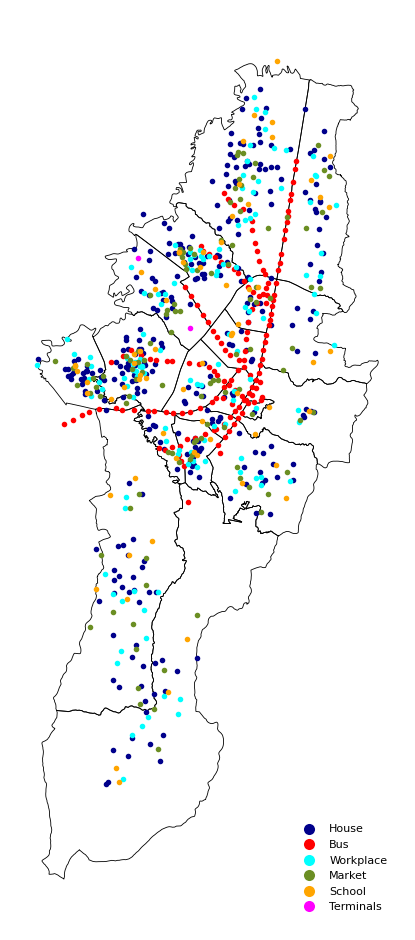

In [9]:
import matplotlib.pylab as plt
from matplotlib.lines import Line2D

myDPI = 200
fig, ax = plt.subplots(
    dpi=myDPI
)  # figsize=( 732.634438/myDPI,  837.435634/myDPI), dpi=myDPI)

mapLocalidades.plot(ax=ax, edgecolor="black", facecolor="none", lw=0.3)


pType = plotData["type"].value_counts().keys()


def changeName(x):
    if x == "H":
        return "House"
    elif x == "S":
        return "School"
    elif x == "M":
        return "Market"
    elif x == "W":
        return "Workplace"
    elif x == "T":
        return "Terminals"
    else:
        return "Bus"


for i, c in zip(pType, ["darkblue", "red", "cyan", "oliveDrab", "orange", "magenta"]):
    # print(i, c)
    ax.scatter(
        plotData[plotData["type"] == i]["x"],
        plotData[plotData["type"] == i]["y"],
        s=1,
        label=changeName(i),
        c=c,
    )

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="House",
        markerfacecolor="darkblue",
        markersize=5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Bus",
        markerfacecolor="red",
        markersize=5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Workplace",
        markerfacecolor="cyan",
        markersize=5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Market",
        markerfacecolor="oliveDrab",
        markersize=5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="School",
        markerfacecolor="orange",
        markersize=5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Terminals",
        markerfacecolor="magenta",
        markersize=5,
    ),
]


ax.axis("off")
ax.legend(
    handles=legend_elements,
    prop={"size": 4},
    fontsize=6,
    loc=4,
    borderpad=0.2,
    frameon=False,
)

fig.tight_layout()
# fig.savefig('bogota_map.pdf', bbox_inches='tight')

## Routes Generation

Given the edges of transmilenio stations generates the shortest routes between any pair of transmilenio stations. It is asummed that buses stop in all stations.

In [10]:
class Path(object):
    vertices = []

    def initarr(self, start, end):
        self.vertices = start + end[1:]

    def __init__(self, start, end):
        self.vertices = [start, end]

    def initv(self, start, end):
        self.initarr(start.vertices, end.vertices)

    def toString(self, separator, names):
        sb = ""
        if len(self.vertices) > 0:
            sb += names[self.source()] + separator + names[self.target()]
            for i in range(len(self.vertices)):
                sb += separator
                sb += names[self.vertices[i]]
        return sb

    def length(self):
        return len(self.vertices)

    def source(self):
        return self.vertices[0] if (len(self.vertices) > 0) else None

    def target(self):
        return self.vertices[-1] if (len(self.vertices) > 0) else None

Used to calculate shortest paths between any pair of nodes.

In [11]:
class Graph(object):
    names = {}
    vertices = []
    routes = []

    def createRoutes(self, source, target):
        for i in range(0, len(source), 1):
            if source[i] not in self.vertices:
                self.vertices.append(source[i])
            if target[i] not in self.vertices:
                self.vertices.append(target[i])

        n = len(self.vertices)

        for i in range(n):
            self.names[self.vertices[i]] = i

        self.routes = []
        computed = []

        for i in range(n):
            fila = []
            for j in range(n):
                fila.append(None)
            self.routes.append(fila)

        for i in range(len(source)):
            s = self.names[source[i]]
            e = self.names[target[i]]
            pathA = Path(s, e)
            pathB = Path(e, s)
            computed.append(pathA)
            computed.append(pathB)

        while len(computed) > 0:
            # print(len(computed))
            for i in range(len(computed)):
                p = computed[i]
                so = p.source()
                ta = p.target()
                self.routes[so][ta] = p
            computed = []

            i = 0
            while i < n:
                # print(i,j)
                j = i + 1
                while j < n:
                    if self.routes[i][j] == None:
                        m = 0
                        while m < n and (
                            m == i
                            or m == j
                            or self.routes[i][m] == None
                            or self.routes[m][j] == None
                        ):
                            m += 1
                        if m < n:
                            pathA = Path(i, j)
                            pathB = Path(j, i)
                            pathA.initv(self.routes[i][m], self.routes[m][j])
                            pathB.initv(self.routes[j][m], self.routes[m][i])
                            computed.append(pathA)
                            computed.append(pathB)
                    j += 1
                i += 1

    def __init__(self, source, target):
        self.createRoutes(source, target)

    def routes(self):
        return self.routes

    def strRoutes(self, separator):
        sb = ""
        for i in range(len(self.routes)):
            for j in range(len(self.routes)):
                if self.routes[i][j] != None:
                    sb += self.routes[i][j].toString(separator, self.vertices)
                    sb += "\n"
        return sb

Generates path between any pair of TM stations

In [12]:
df = pd.read_csv('./Data/Transmilenio.edge.csv', usecols=[0,1])
df        

,Source,Target
0,San Mateo,Terreros - Hospital C.V
1,Terreros - Hospital C.V,Leon XIII
2,Leon XIII,La Despensa
3,La Despensa,Bosa
4,Bosa,Portal del Sur
...,...,...
147,CAD,Recinto Ferial
148,Comuneros,Guatoque - Veraguas
149,Guatoque - Veraguas,Tygua - San José
150,Ricaurte - NQS,Ricaurte - CL 13


In [13]:
d = Graph(df["Source"].tolist(), df["Target"].tolist())
strRoutes = d.strRoutes(",")

with open("./Data/paths.csv", "w", encoding="UTF-8") as f:
    for line in strRoutes:
        f.write(line)

# Print the first 10 paths
for path1 in strRoutes.split("\n")[:10]:
    print(path1)

San Mateo,Terreros - Hospital C.V,San Mateo,Terreros - Hospital C.V
San Mateo,Leon XIII,San Mateo,Terreros - Hospital C.V,Leon XIII
San Mateo,La Despensa,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa
San Mateo,Bosa,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa
San Mateo,Portal del Sur,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa,Portal del Sur
San Mateo,Perdomo,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa,Portal del Sur,Perdomo
San Mateo,Madelena,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa,Portal del Sur,Perdomo,Madelena
San Mateo,Sevillana,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa,Portal del Sur,Perdomo,Madelena,Sevillana
San Mateo,Venecia,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa,Portal del Sur,Perdomo,Madelena,Sevillana,Venecia
San Mateo,Alquería,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa,Portal del Sur,Perdomo,Madelena,Sevillana,Venecia,Alquería


## Graph generation
Utility functions to generate a graph with all the connections between places and also a file with routes corresponding to each person. Additionally generates routes to all the people in the simulation based on an input file.

In [14]:
# Implements class coordinate that corresponds to places in the simulations: Home, Market, Terminal, School or Bus
class coordinate:
    def __init__(self, x, y, typ, name, idx):
        self.x = x
        self.y = y
        self.type = typ
        self.name = name
        self.idx = idx

    def __lt__(self, other):
        return self.x < other.x or (self.x == other.x and self.y < other.y)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def getdistance(self, other):
        x = self.x - other.x
        y = self.y - other.y
        return math.sqrt(x * x + y * y)

    def __str__(self):
        strb = "x= "
        strb += str(self.x)
        strb += ", y="
        strb += str(self.y)
        strb += ", type="
        strb += str(self.type)
        strb += ", name="
        strb += str(self.name)
        return strb

Utility functions to load transmilenio stations and places from csv files

In [15]:
def loadtmcoordinates(coordinates):
    df = pd.read_csv(
        "./Data/estaciones.csv",
        usecols=[0, 1, 5, 6],
        encoding="ISO-8859-1",
        header=None,
    )
    for i in range(len(df[0])):
        c = coordinate(df[0][i], df[1][i], "B", df[6][i], df[5][i])
        coordinates.append(c)


def getclosestpoint(coordinates, orig):
    min = sys.float_info.max
    for c in coordinates:
        dist = c.getdistance(orig)
        if dist < min:
            closest = c
            min = dist
    return closest


def loadplaces(coordinates):
    df = pd.read_csv(
        "./Data/places.csv", usecols=[0, 1, 2, 3], encoding="ISO-8859-1", header=0
    )
    # print(len(df["Id"]))
    # print(df)
    for i in range(len(df["Id"])):
        idx = df["Id"][i]
        dx = df["X"][i]
        dy = df["Y"][i]
        ty = df["Tipo"][i]

        name = ""
        if ty == "H":
            name = "House" + str(idx)
        elif ty == "W":
            name = "Work" + str(idx)
        elif ty == "S":
            name = "School" + str(idx)
        elif ty == "T":
            name = "Terminal" + str(idx)
        elif ty == "M":
            name = "Market" + str(idx)
        else:
            name = "Unknown" + str(idx)
        c = coordinate(dx, dy, ty, name, idx)
        # print(str(c))
        coordinates.append(c)


def getid(name, estations):
    for e in estations:
        if e.name == name:
            return e.idx
    return None


def generateTMroute(closestP, estD, tm):
    hm = {}
    pathsfile = "./Data/paths.csv"
    with open(pathsfile, "r", encoding="utf-8") as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        for l in lines:
            arr = l.rstrip().split(",")
            # print(arr)
            cad = arr[0] + "-" + arr[1]
            # print(cad)
            line = l[len(cad) + 1 :]
            hm[cad] = line.strip()
            # print(cad + " : " +hm[cad])

    out = closestP.name + "-" + estD.name
    indications = hm[out].split(",")
    output = ""
    i = 0
    for s in indications:
        output += str(getid(s, tm))
        if i < len(indications) - 1:
            output += ","
        i += 1
    # print(output)
    return output

Generates a total graph without including edges of TM in gephi format. In the research TM station were added to this file via copy paste.

In [16]:
stations = []
places = []
loadplaces(places)
loadtmcoordinates(stations)
sorted(stations)
with open("./Data/nodePlaces.csv", "w") as f:
    f.write("Id,Type\n")
    for c in places:
        f.write(c.name + "," + c.type + "\n")
    for e in stations:
        f.write(e.name + "," + e.type + "\n")

with open("./Data/edgePlaces.csv", "w") as f:
    f.write("Source,Target,Type\n")
    for orig in places:
        closestP = getclosestpoint(stations, orig)
        f.write(orig.name + "," + closestP.name + ",Undirected\n")

## Assignation of routes to each person

This part of the notebook defines persons and assign a plan using the file of routes

In [17]:
class person:
    def __init__(self, age, gender, orig):
        self.age = age
        self.gender = gender
        self.orig = orig

    def __str__():
        return (
            "Person{"
            + " age="
            + self.age
            + ", gender="
            + self.gender
            + ", orig="
            + self.orig
            + ", dest="
            + self.dest
            + "}"
        )


import random


def loadplacesarrays(houses, works, schools, terminals, markets, dictHouses):
    df = pd.read_csv(
        "./Data/places.csv", usecols=[0, 1, 2, 3], encoding="ISO-8859-1", header=0
    )
    # print(len(df["Id"]))
    # print(df)
    for i in range(len(df["Id"])):
        idx = df["Id"][i]
        dx = df["X"][i]
        dy = df["Y"][i]
        ty = df["Tipo"][i]

        name = ""
        if ty == "H":
            name = str(idx)
            c = coordinate(dx, dy, ty, name, idx)
            dictHouses[idx] = c
        else:
            name = str(idx)
        c = coordinate(dx, dy, ty, name, idx)

        name = ""
        if ty == "H":
            houses.append(c)
        elif ty == "W":
            works.append(c)
        elif ty == "S":
            schools.append(c)
        elif ty == "T":
            terminals.append(c)
        elif ty == "M":
            markets.append(c)


def loadpeople():
    persons = []
    houses = []
    works = []
    schools = []
    terminals = []
    markets = []
    people = []
    dicthouses = {}

    loadplacesarrays(houses, works, schools, terminals, markets, dicthouses)

    idn = 0
    houseid = 0
    schoolid = 0
    worksid = 0
    marketsid = 0

    df = pd.read_csv(
        "./Data/people.csv", usecols=[1, 2, 3], encoding="ISO-8859-1", header=None
    )
    # print(len(df[1]))
    print(df)
    for i in range(len(df[1])):
        home = dicthouses[df[3][i]]
        p = person(df[1][i], df[2][i], home)

        if p.age == 1 or p.age == 2:
            p.dest = schools[schoolid % len(schools)]
            schoolid += 1
        elif p.age == 3 or p.age == 4:
            if random.uniform(0, 1) >= 0.105:  # unemployment rate
                p.dest = works[worksid % len(works)]
                worksid += 1
            else:
                p.dest = markets[marketsid % len(markets)]
                marketsid += 1
        elif p.age == 5:
            p.dest = markets[marketsid % len(markets)]
            marketsid += 1
        persons.append(p)

    return persons

Function to create and assign routes to persons

In [18]:
people = loadpeople()
coordinates = []

with open("./Data/routes.csv", "w") as f:
    for person in people:
        orig = person.orig
        dest = person.dest
        coordinates = []
        loadtmcoordinates(coordinates)
        coordinates.append(dest)
        sorted(coordinates)

        closest = getclosestpoint(coordinates, orig)

        if closest.name == dest.name:  # no tm needed
            f.write(str(person.orig.idx) + "," + str(person.dest.idx) + "\n")
        else:
            coordinates = []
            loadtmcoordinates(coordinates)
            estd = getclosestpoint(coordinates, dest)

            if closest.name == estd.name:
                f.write(str(person.orig.idx) + "," + str(person.dest.idx) + "\n")
            else:
                f.write(
                    str(person.orig.idx)
                    + ","
                    + generateTMroute(closest, estd, coordinates)
                    + ","
                    + str(person.dest.idx)
                    + "\n"
                )

     1  2    3
0    3  F  302
1    2  F   90
2    1  F  227
3    4  M   37
4    1  M  260
..  .. ..  ...
995  2  F  226
996  4  M   85
997  1  F  284
998  1  F  150
999  3  M  213

[1000 rows x 3 columns]


In [19]:
def calculate_max_columns(file_path):
    max_columns = 0
    with open(file_path, "r") as file:
        for line in file:
            columns = line.split(",")
            max_columns = max(max_columns, len(columns))
    return max_columns


# Calculate the maximum number of columns in the CSV file
file_path = "./Data/routes.csv"
max_columns = calculate_max_columns(file_path)
print(f"The maximum number of columns in the CSV file is: {max_columns}")

The maximum number of columns in the CSV file is: 67


Visualize the routes for each individual

In [20]:
import pandas as pd

# Define column names for 67 columns
column_names = [f"col{i}" for i in range(1, 68)]

# Read the CSV file with 67 columns
dataRoutes = pd.read_csv(
    "./Data/routes.csv", header=None, names=column_names, on_bad_lines="warn"
)

# Print the first few rows to verify
print(dataRoutes.head())

   col1   col2     col3     col4     col5     col6     col7     col8     col9  \
0   302   9000   9001.0   9002.0   9003.0   9004.0   9100.0   9101.0   9103.0   
1    90   7506   7010.0   7000.0   7001.0   7002.0   7003.0   7004.0   7005.0   
2   227    311      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3    37  10003  10004.0  10010.0  10005.0  10006.0   9110.0  14001.0  12004.0   
4   260   5107  12000.0  12001.0  12007.0  12002.0  12003.0   7111.0   7112.0   

     col10  ...   col58   col59   col60   col61   col62  col63  col64  col65  \
0   9104.0  ...  2103.0  2102.0  2101.0  2000.0  2001.0  488.0    NaN    NaN   
1   7006.0  ...     NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2      NaN  ...     NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
3  12003.0  ...     NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
4   7113.0  ...     NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   

   col66  col67  
0    NaN    Na

## Assign routes for the population

In [21]:
def changeRoute(x):
    xlist = x.dropna().tolist()
    return ",".join(map(str, map(int, xlist)))


dataRoutes["route"] = dataRoutes.apply(changeRoute, axis=1)


dataRoutes["homeID"] = dataRoutes["route"].apply(lambda x: int(x[0]))
dataRoutes["placeID"] = dataRoutes["route"].apply(lambda x: int(x[-1]))

dataRoutes = dataRoutes[["homeID", "placeID", "route"]]

dataPeople = pd.read_csv("./Data/people.csv", header=None)
dataPeople.columns = ["district", "age", "gender", "id"]
dataPeople = dataPeople[["age", "gender", "district"]]
dataPeople = pd.concat([dataPeople, dataRoutes], axis=1)


dataPeople.head()

,age,gender,district,homeID,placeID,route
0,3,F,6,3,8,"302,9000,9001,9002,9003,9004,9100,9101,9103,91..."
1,2,F,1,9,0,"90,7506,7010,7000,7001,7002,7003,7004,7005,700..."
2,1,F,5,2,1,"227,311"
3,4,M,7,3,9,"37,10003,10004,10010,10005,10006,9110,14001,12..."
4,1,M,19,2,2,"260,5107,12000,12001,12007,12002,12003,7111,71..."


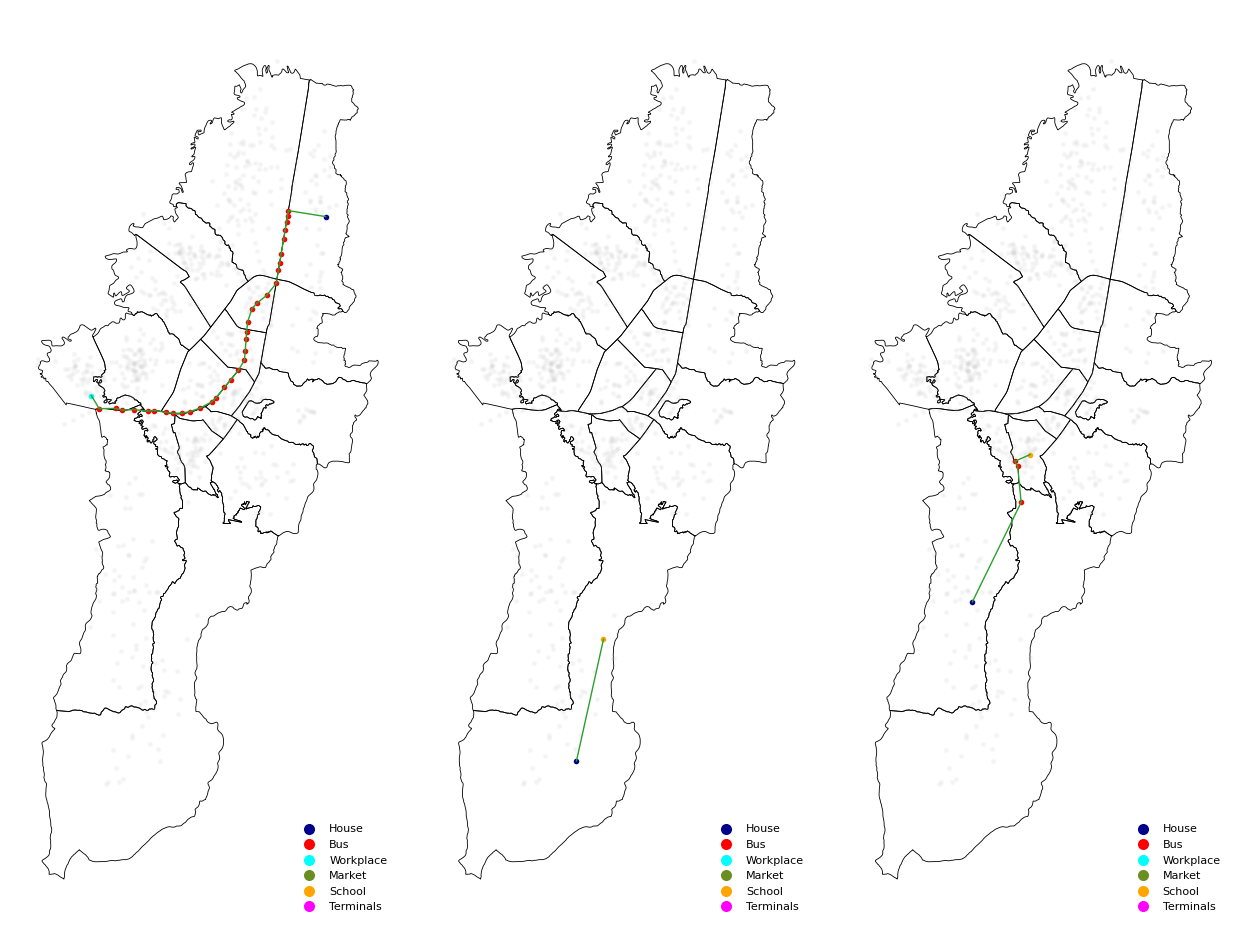

In [22]:
myDPI = 200
fig, ax = plt.subplots(
    1, 3, dpi=myDPI
)  # figsize=( 732.634438/myDPI,  837.435634/myDPI), dpi=myDPI)


pType = plotData["type"].value_counts().keys()


def color(x):
    if x == "H":
        return "darkblue"
    elif x == "S":
        return "orange"
    elif x == "M":
        return "oliveDrab"
    elif x == "W":
        return "cyan"
    elif x == "T":
        return "magenta"
    else:
        return "red"


random_individual = [np.random.randint(num_people) for i in range(3)]
# toPlotIndividuals = [230, 19, 55, 822, 790, 5, 15, 999, 82, 564]
toPlotIndividuals = random.sample(random_individual, 3)  # [55, 5, 999, ]

for index, random_individual in enumerate(toPlotIndividuals):

    mapLocalidades.plot(ax=ax[index], edgecolor="black", facecolor="none", lw=0.3)

    # print(dataPeople.iloc[random_individual])

    routes = dataPeople.iloc[random_individual]["route"]
    routes = list(map(int, routes.split(",")))

    for i in range(len(routes) - 1):
        place1 = plotData[plotData["id"] == routes[i]]
        place2 = plotData[plotData["id"] == routes[i + 1]]

        ax[index].plot(
            [place1["x"].values[0], place2["x"].values[0]],
            [place1["y"].values[0], place2["y"].values[0]],
            c="C2",
            lw=0.5,
        )

    ax[index].scatter(plotData["x"], plotData["y"], s=1, c="silver", alpha=0.1)

    for i in routes:
        place = plotData[plotData["id"] == i]
        ax[index].scatter(place["x"], place["y"], s=1, c=color(place["type"].values[0]))

    from matplotlib.lines import Line2D

    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="House",
            markerfacecolor="darkblue",
            markersize=5,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Bus",
            markerfacecolor="red",
            markersize=5,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Workplace",
            markerfacecolor="cyan",
            markersize=5,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Market",
            markerfacecolor="oliveDrab",
            markersize=5,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="School",
            markerfacecolor="orange",
            markersize=5,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Terminals",
            markerfacecolor="magenta",
            markersize=5,
        ),
    ]

    ax[index].axis("off")
    ax[index].legend(
        handles=legend_elements,
        prop={"size": 4},
        fontsize=6,
        loc=4,
        borderpad=0.2,
        frameon=False,
    )

fig.tight_layout()

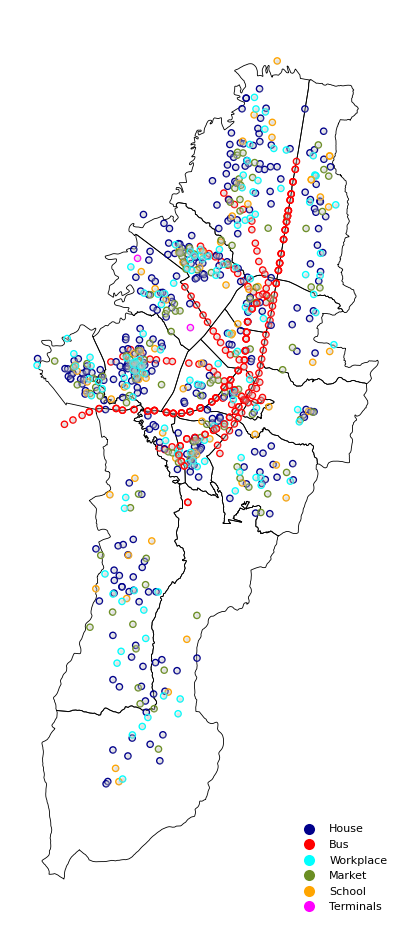

In [23]:
myDPI = 200
fig, ax = plt.subplots(
    1, 1, dpi=myDPI
)  # figsize=( 732.634438/myDPI,  837.435634/myDPI), dpi=myDPI)


pType = plotData["type"].value_counts().keys()


def color(x):
    if x == "H":
        return "darkblue"
    elif x == "S":
        return "orange"
    elif x == "M":
        return "oliveDrab"
    elif x == "W":
        return "cyan"
    elif x == "T":
        return "magenta"
    else:
        return "red"


mapLocalidades.plot(ax=ax, edgecolor="black", facecolor="none", lw=0.3)

# print(dataPeople.iloc[random_individual])

for place in plotData.iterrows():
    ax.scatter(
        place[1]["x"],
        place[1]["y"],
        s=5,
        edgecolors=color(place[1]["type"]),
        facecolors="none",
        linewidths=0.5,
    )

for random_individual in range(0, 3):
    routes = dataPeople.iloc[random_individual]["route"]
    routes = list(map(int, routes.split(",")))

    # for i in range(len(routes) - 1):
    #     place1 = plotData[plotData["id"] == routes[i]]
    #     place2 = plotData[plotData["id"] == routes[i + 1]]

    #     ax.plot(
    #         [place1["x"].values[0], place2["x"].values[0]],
    #         [place1["y"].values[0], place2["y"].values[0]],
    #         c="2",
    #         lw=0.5,
    #     )

    ax.scatter(plotData["x"], plotData["y"], s=1, c="silver", alpha=0.1)

    for i in routes:
        place = plotData[plotData["id"] == i]
        ax.scatter(
            place["x"],
            place["y"],
            s=5,
            edgecolors=color(place["type"].values[0]),
            facecolors="none",
            linewidths=0.5,
        )


from matplotlib.lines import Line2D


legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="House",
        markerfacecolor="darkblue",
        markersize=5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Bus",
        markerfacecolor="red",
        markersize=5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Workplace",
        markerfacecolor="cyan",
        markersize=5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Market",
        markerfacecolor="oliveDrab",
        markersize=5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="School",
        markerfacecolor="orange",
        markersize=5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Terminals",
        markerfacecolor="magenta",
        markersize=5,
    ),
]


ax.axis("off")
ax.legend(
    handles=legend_elements,
    prop={"size": 4},
    fontsize=6,
    loc=4,
    borderpad=0.2,
    frameon=False,
)

fig.tight_layout()

In [24]:
plotData

,id,x,y,type,name
0,4003,-74.100288,4.702486,B,AV. Cali
1,7004,-74.142650,4.595567,B,Venecia
2,4105,-74.077401,4.681821,B,Carrera 53
3,7104,-74.077663,4.657291,B,Simón Bolívar
4,4000,-74.110506,4.709829,B,Portal de la 80
...,...,...,...,...,...
613,614,-74.156735,4.470372,W,
614,615,-74.165320,4.462790,W,
615,616,-74.162692,4.535096,W,
616,617,-74.154447,4.701424,T,


In [25]:
import pandas as pd
import random

# Load predefined routes from routes.csv
# Define column names for 67 columns
column_names = [f"col{i}" for i in range(1, 68)]

# Time ticks (24 hours in a day)
ticks = 24


# Define a function to calculate the variable transit time based on route size
def calculate_transit_time(route):
    # Transit time is proportional to the number of steps in the route (excluding home and destination)
    return (
        len(route) - 2 if len(route) > 2 else 1
    )  # At least 1 tick if route has only home and destination


# Define a routine generation function for each individual
def generate_routine(person_id, route):
    routine = []

    # Transit times based on the length of the route
    transit_time_to_work = calculate_transit_time(route)  # Transit time to work/school
    transit_time_to_home = calculate_transit_time(route[::-1])  # Transit time back home

    # Define basic time slots (e.g., 8 hours at work/school, 10 hours at home)
    home_time = [0, 7]  # 0-7: Home
    transit_to_work_start = home_time[1] + 1
    work_start_time = transit_to_work_start + transit_time_to_work
    work_time = [work_start_time, 17]  # Work/school from 9 to 17 minus transit time
    transit_to_home_start = work_time[1] + 1
    evening_home = [
        transit_to_home_start + transit_time_to_home,
        23,
    ]  # Back home in the evening

    # Simulate a daily routine with 24 hours
    for t in range(ticks):
        if t in range(home_time[0], home_time[1] + 1):  # Home in the morning
            routine.append(route[0])  # Home
        elif (
            home_time[1] < t <= home_time[1] + transit_time_to_work
        ):  # In transit to work
            transit_index = (
                t - home_time[1] - 1
            )  # Calculate the correct index in the route
            routine.append(route[transit_index + 1])  # Transit to work
        elif t in range(work_time[0], work_time[1] + 1):  # At work/school
            routine.append(route[-1])  # Final destination (work/school/market)
        elif (
            work_time[1] < t <= work_time[1] + transit_time_to_home
        ):  # In transit back home
            transit_index = (
                t - work_time[1] - 1
            )  # Calculate the correct index in the reversed route
            routine.append(route[::-1][transit_index + 1])  # Transit back home
        else:  # Home in the evening
            routine.append(route[0])  # Home again by default

    return routine


# Generate routines for all people using predefined routes
people_routines = []

for person_id in range(len(dataPeople)):
    # Load the person's route from routes.csv
    route = dataPeople.iloc[person_id]["route"].split(",")
    # Generate the routine based on the predefined route
    routine = generate_routine(person_id, route)
    people_routines.append({"person_id": person_id, "routine": routine})

# Convert to DataFrame
routines_df = pd.DataFrame(people_routines)

# Save the routine data into a CSV file
routines_df.to_csv("./Data/daily_routines.csv", index=False)

routines_df.head()

,person_id,routine
0,0,"[302, 302, 302, 302, 302, 302, 302, 302, 9000,..."
1,1,"[90, 90, 90, 90, 90, 90, 90, 90, 7506, 7010, 7..."
2,2,"[227, 227, 227, 227, 227, 227, 227, 227, 311, ..."
3,3,"[37, 37, 37, 37, 37, 37, 37, 37, 10003, 10004,..."
4,4,"[260, 260, 260, 260, 260, 260, 260, 260, 5107,..."


In [26]:
import pandas as pd
import random
import os
from tqdm import tqdm
import ast
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

# Time ticks (288 for 24 hours in 5-minute intervals)
ticks = 288

output_dir = "./Data/people_positions/"
os.makedirs(output_dir, exist_ok=True)


def calculate_transit_time(route):
    return (
        len(route) - 2 if len(route) > 2 else 1
    )  # At least 1 tick if route has only home and destination


def generate_routine(person_id, route):
    routine = []

    transit_time_to_work = calculate_transit_time(route)  # Transit time to work/school
    transit_time_to_home = calculate_transit_time(route[::-1])  # Transit time back home

    # Define basic time slots (e.g., 8 hours at work/school, 10 hours at home)
    home_time = [0, 23]  # 0-23: Home (for 24 5-minute intervals)
    transit_to_work_start = home_time[1] + 1
    work_start_time = transit_to_work_start + transit_time_to_work
    work_time = [
        work_start_time,
        work_start_time + 96,
    ]  # 8 hours at work/school (96 5-minute intervals)
    transit_to_home_start = work_time[1] + 1
    evening_home = [
        transit_to_home_start + transit_time_to_home,
        287,
    ]  # Back home in the evening

    for t in range(ticks):
        if t in range(home_time[0], home_time[1] + 1):  # Home in the morning
            routine.append(route[0])  # Home
        elif (
            home_time[1] < t <= home_time[1] + transit_time_to_work
        ):  # In transit to work
            transit_index = (
                t - home_time[1] - 1
            )  # Calculate the correct index in the route
            routine.append(route[transit_index + 1])  # Transit to work
        elif t in range(work_time[0], work_time[1] + 1):  # At work/school
            routine.append(route[-1])  # Final destination (work/school/market)
        elif (
            work_time[1] < t <= work_time[1] + transit_time_to_home
        ):  # In transit back home
            transit_index = (
                t - work_time[1] - 1
            )  # Calculate the correct index in the reversed route
            routine.append(route[::-1][transit_index + 1])  # Transit back home
        else:  # Home in the evening
            routine.append(route[0])  # Home again by default

    return routine


people_routines = []

for person_id in range(len(dataPeople)):
    route = dataPeople.iloc[person_id]["route"].split(
        ","
    )  # Ensure this splits correctly
    routine = generate_routine(person_id, route)
    people_routines.append({"person_id": person_id, "routine": routine})

routines_df = pd.DataFrame(people_routines)

routines_df.to_csv("./Data/daily_routines.csv", index=False)

mapLocalidades = gpd.read_file("./Data/locashp")
mapLocalidades = mapLocalidades[mapLocalidades["LocCodigo"] != "20"]

routines_df = pd.read_csv("./Data/daily_routines.csv")
routines_df

,person_id,routine
0,0,"['302', '302', '302', '302', '302', '302', '30..."
1,1,"['90', '90', '90', '90', '90', '90', '90', '90..."
2,2,"['227', '227', '227', '227', '227', '227', '22..."
3,3,"['37', '37', '37', '37', '37', '37', '37', '37..."
4,4,"['260', '260', '260', '260', '260', '260', '26..."
...,...,...
995,995,"['226', '226', '226', '226', '226', '226', '22..."
996,996,"['85', '85', '85', '85', '85', '85', '85', '85..."
997,997,"['284', '284', '284', '284', '284', '284', '28..."
998,998,"['150', '150', '150', '150', '150', '150', '15..."


In [27]:
# import matplotlib.pyplot as plt
# import ast
# from tqdm import tqdm
# import os
# import numpy as np

# # Set up the base plot
# fig, ax = plt.subplots(dpi=200, figsize=(12, 10))

# # Plot the base map (custom background with place types)
# mapLocalidades.plot(ax=ax, edgecolor="black", facecolor="none", lw=0.3)
# for place in plotData.iterrows():
#     ax.scatter(
#         place[1]["x"],
#         place[1]["y"],
#         s=5,
#         edgecolors=color(place[1]["type"]),
#         facecolors="none",
#         linewidths=0.5,
#     )

# # Remove axes
# ax.axis('off')

# # Create a scatter plot object for people's positions
# # Use grey color with opacity 0.5
# people_scatter = ax.scatter([], [], s=1, c='grey', alpha=0.5)

# for tick in tqdm(range(ticks), desc="Generating images"):
#     # Update people positions at hour `tick`
#     x_positions = []
#     y_positions = []

#     for i, row in routines_df.iterrows():
#         routine = ast.literal_eval(row["routine"])
#         place_id = int(routine[tick])

#         place = plotData[plotData["id"] == place_id]
#         x_positions.append(place["x"].values[0])
#         y_positions.append(place["y"].values[0])

#     # Update the scatter plot
#     people_scatter.set_offsets(np.c_[x_positions, y_positions])

#     if tick < 10:
#         tick_string = f"00{tick}"
#     elif tick < 100:
#         tick_string = f"0{tick}"
#     else:
#         tick_string = f"{tick}"

#     ax.set_title(f"People's Positions at Tick {tick_string}")

#     # Save the figure
#     file_name = f"{tick_string}.png"
#     plt.savefig(os.path.join(output_dir, file_name), bbox_inches="tight")

#     # Clear the title for the next iteration
#     ax.set_title("")

# # Close the figure at the end
# plt.close(fig)

In [28]:
# 

In [29]:
import pandas as pd
import numpy as np
import random

# Constants and Parameters
ALPHA = 0.1  # Transmission rate from Susceptible to Exposed
BETA = 0.4  # Transmission rate from Exposed to Seriously-Infected
THETA = 0.4  # Transmission rate from Seriously-Infected to Critically-Infected
PHI = 0.1    # Death rate for Critically-Infected individuals
OMEGA = 0.1  # Immune rate for Recovered individuals
TICKS_PER_DAY = 288  # 5-minute intervals per day

# Health states
STATES = {
    'S': 'Susceptible',
    'E': 'Exposed',
    'IS': 'Seriously-Infected',
    'IC': 'Critically-Infected',
    'R': 'Recovered',
    'M': 'Immune',
    'D': 'Dead'
}

# Time periods individuals must stay in each state (in days)
TIME_PERIODS = {
    'E': 5,   # Exposed to Seriously-Infected or Recovered
    'IS': 5,  # Seriously-Infected to Critically-Infected or Recovered
    'IC': 5,  # Critically-Infected to Dead or Recovered
    'R': 5    # Recovered to Immune or Susceptible
}

# Load data
people = dataPeople.copy()  # Assume dataPeople contains columns: 'age', 'gender', 'district', etc.
people['state'] = STATES['S']

# Initialize 'state_entry_day' column to keep track of when an individual entered their current state
initial_day = 0  # Start of the simulation (day 0)
people['state_entry_day'] = initial_day

# Initial Exposure: Infect some individuals
initial_exposed = [0, 10, 50]  # Assume these individuals are initially exposed
people.loc[initial_exposed, 'state'] = STATES['E']
people.loc[initial_exposed, 'state_entry_day'] = initial_day

# Load individual routines (daily movements)
routines_df = pd.read_csv('./Data/daily_routines.csv')  # Assuming daily routines file

people

,age,gender,district,homeID,placeID,route,state,state_entry_day
0,3,F,6,3,8,"302,9000,9001,9002,9003,9004,9100,9101,9103,91...",Exposed,0
1,2,F,1,9,0,"90,7506,7010,7000,7001,7002,7003,7004,7005,700...",Susceptible,0
2,1,F,5,2,1,"227,311",Susceptible,0
3,4,M,7,3,9,"37,10003,10004,10010,10005,10006,9110,14001,12...",Susceptible,0
4,1,M,19,2,2,"260,5107,12000,12001,12007,12002,12003,7111,71...",Susceptible,0
...,...,...,...,...,...,...,...,...
995,2,F,9,2,9,"226,2502,2001,2000,2101,2102,2103,2104,2105,22...",Susceptible,0
996,4,M,12,8,1,"85,5000,5001,5002,5005,5100,5101,5102,5103,510...",Susceptible,0
997,1,F,3,2,0,"284,9000,9001,9002,9003,9004,9100,9101,9103,91...",Susceptible,0
998,1,F,3,1,1,"150,6000,6001,6002,6100,6101,6102,6103,6104,61...",Susceptible,0


In [30]:
# Extract routines for all individuals
from ast import literal_eval


routines = routines_df.set_index('person_id')['routine'].apply(literal_eval).to_dict()

# Example: Define mean contact for each type of place
mean_contact_values = {
    'H': 1,  # Home
    'B': 5,  # Bus Station
    'W': 3,  # Workplace
    'M': 4,  # Market
    'S': 2,  # School
    'T': 3,  # Terminal
}

def get_mean_contact(location_type):
    return mean_contact_values.get(location_type, 1)

# Continue recording interactions
def record_interactions(people, routines, current_tick):
    locations = {}
    interaction_record = {person_id: {'total_exposure_minutes': 0} for person_id in people.index}

    # Get current locations of individuals at the given tick
    for person_id, routine in routines.items():
        current_location = routine[current_tick]
        if current_location not in locations:
            locations[current_location] = []
        locations[current_location].append(person_id)

    # Calculate exposure
    for location, persons in locations.items():
        # Check if infected individuals are present at this location
        infected_present = [person for person in persons if people.at[person, 'state'] in [STATES['E'], STATES['IS'], STATES['IC']]]
        
        if infected_present:
            # Determine the number of interactions for each susceptible individual
            susceptible_persons = [person for person in persons if people.at[person, 'state'] == STATES['S']]
            if susceptible_persons:
                location_type = plotData[plotData['id'] == int(location)]['type'].values[0]
                mean_contact = get_mean_contact(location_type) 

                # Limit interactions based on mean contact
                for person in susceptible_persons:
                    # The actual number of infected individuals interacting with this person
                    actual_contacts = min(len(infected_present), mean_contact)
                    
                    if actual_contacts > 0:
                        # Calculate the infection probability
                        alpha = ALPHA
                        probability_not_infected = (1 - alpha) ** actual_contacts
                        probability_of_infection = 1 - probability_not_infected
                        
                        # Record exposure time (5 minutes per tick)
                        exposure_time = 5  # in minutes
                        if random.uniform(0, 1) < probability_of_infection:
                            interaction_record[person]['total_exposure_minutes'] += exposure_time

    return interaction_record


In [31]:
def update_health_state(people, interaction_record, current_day):
    """
    Update the health state of each person at the end of the day based on daily interactions and time spent in states.

    Args:
    - people: DataFrame containing current health states of individuals, their state entry times, etc.
    - interaction_record: Dictionary containing interaction data for each person
    - current_day: Current day of the simulation (int)

    Returns:
    - Updated DataFrame of people with new health states
    """
    
    for person_id, person in people.iterrows():
        current_state = person['state']
        state_entry_day = person['state_entry_day']
        
        # Skip dead individuals
        if current_state == STATES['D']:
            continue

        # Calculate the total exposure time to infected individuals
        interaction_data = interaction_record[person_id]
        total_exposure_time = interaction_data.get('total_exposure_minutes', 0)
        
        # Check how long the person has been in the current state
        days_in_state = current_day - state_entry_day

        # Update health state based on current state, exposure time, and time spent in the state
        if current_state == STATES['S'] and days_in_state >= 0:  # Susceptible to Exposed
            probability_of_infection = 1 - np.exp(-ALPHA * total_exposure_time / 60)
            if random.uniform(0, 1) < probability_of_infection:
                people.at[person_id, 'state'] = STATES['E']
                people.at[person_id, 'state_entry_day'] = current_day

        elif current_state == STATES['E'] and days_in_state >= TIME_PERIODS['E']:  # Exposed to Seriously-Infected or Recovered
            if random.uniform(0, 1) < BETA:
                people.at[person_id, 'state'] = STATES['IS']
            else:
                people.at[person_id, 'state'] = STATES['R']
            people.at[person_id, 'state_entry_day'] = current_day

        elif current_state == STATES['IS'] and days_in_state >= TIME_PERIODS['IS']:  # Seriously-Infected to Critically-Infected or Recovered
            if random.uniform(0, 1) < THETA:
                people.at[person_id, 'state'] = STATES['IC']
            else:
                people.at[person_id, 'state'] = STATES['R']
            people.at[person_id, 'state_entry_day'] = current_day

        elif current_state == STATES['IC'] and days_in_state >= TIME_PERIODS['IC']:  # Critically-Infected to Dead or Recovered
            if random.uniform(0, 1) < PHI:
                people.at[person_id, 'state'] = STATES['D']
            else:
                people.at[person_id, 'state'] = STATES['R']
            people.at[person_id, 'state_entry_day'] = current_day

        elif current_state == STATES['R'] and days_in_state >= TIME_PERIODS['R']:  # Recovered to Immune or Susceptible
            if random.uniform(0, 1) < OMEGA:
                people.at[person_id, 'state'] = STATES['M']
            else:
                people.at[person_id, 'state'] = STATES['S']
            people.at[person_id, 'state_entry_day'] = current_day

    return people

In [32]:
# # Simulation settings
# NUM_DAYS = 300 # Number of days to simulate

# # Prepare to track statistics
# statistics = []

# for day in range(NUM_DAYS):
#     # Reset interaction record for the new day
#     interaction_record = {person_id: {'total_exposure_minutes': 0} for person_id in people.index}
    
#     # Record interactions for each tick in the day
#     for tick in range(TICKS_PER_DAY):
#         current_tick = tick
#         tick_interaction_record = record_interactions(people, routines, current_tick)
        
#         # Accumulate exposure times
#         for person_id in tick_interaction_record:
#             interaction_record[person_id]['total_exposure_minutes'] += tick_interaction_record[person_id]['total_exposure_minutes']

#     # Update health states at the end of the day
#     people = update_health_state(people, interaction_record, day)
    
#     # Record statistics for the day
#     daily_statistics = people['state'].value_counts().to_dict()
#     print(f"Day {day}: {daily_statistics}")
#     statistics.append(daily_statistics)

# # Convert statistics to DataFrame
# statistics_df = pd.DataFrame(statistics)
# statistics_df


In [33]:
# reordered_columns = [
#     'Susceptible',          # Susceptible should be at the bottom
#     'Exposed',              # Then Exposed
#     'Seriously-Infected',   # Then Seriously Infected
#     'Critically-Infected',  # Then Critically Infected
#     'Recovered',            # Then Recovered
#     'Immune',               # Then Immune
#     'Dead'                  # Finally Dead
# ]

# # Reorder the dataframe according to the logical flow
# statistics_df = statistics_df[reordered_columns].fillna(0)
# statistics_df

In [34]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Colors to match the example plot
# colors = [
#     'limegreen',    # Susceptible
#     'gold',         # Exposed
#     'orangered',    # Seriously Infected
#     'brown',        # Critically Infected
#     'dodgerblue',   # Recovered
#     'purple',       # Immune
#     'gray'          # Dead
# ]

# # Plotting the area chart with more customization
# plt.figure(figsize=(12, 6))

# # Stackplot with specific colors and transparency for better visualization
# plt.stackplot(statistics_df.index,
#               statistics_df['Susceptible'],
#               statistics_df['Exposed'],
#               statistics_df['Seriously-Infected'],
#               statistics_df['Critically-Infected'],
#               statistics_df['Recovered'],
#               statistics_df['Immune'],
#               statistics_df['Dead'],
#               labels=statistics_df.columns,
#               colors=colors,
#               alpha=0.6)  # Set transparency for overlapping visualization

# # Adding title and axis labels
# plt.title('Epidemic Dynamics Over Time', fontsize=16, fontweight='bold', pad=20)
# plt.xlabel('Time (Days)', fontsize=12)
# plt.ylabel('Number of Individuals', fontsize=12)

# # Adding grid for better readability
# plt.grid(axis='y', linestyle='--', alpha=0.5)

# # Adding legend with customization
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=10, frameon=False)

# # Setting limits for the axes for better readability (Optional)
# plt.xlim(0, statistics_df.index[-1])
# plt.ylim(0, num_people)  # Assuming the total number of individuals is around 1000 for better control

# # Show the final plot
# plt.tight_layout()
# plt.show()



In [35]:
dataPeople

,age,gender,district,homeID,placeID,route
0,3,F,6,3,8,"302,9000,9001,9002,9003,9004,9100,9101,9103,91..."
1,2,F,1,9,0,"90,7506,7010,7000,7001,7002,7003,7004,7005,700..."
2,1,F,5,2,1,"227,311"
3,4,M,7,3,9,"37,10003,10004,10010,10005,10006,9110,14001,12..."
4,1,M,19,2,2,"260,5107,12000,12001,12007,12002,12003,7111,71..."
...,...,...,...,...,...,...
995,2,F,9,2,9,"226,2502,2001,2000,2101,2102,2103,2104,2105,22..."
996,4,M,12,8,1,"85,5000,5001,5002,5005,5100,5101,5102,5103,510..."
997,1,F,3,2,0,"284,9000,9001,9002,9003,9004,9100,9101,9103,91..."
998,1,F,3,1,1,"150,6000,6001,6002,6100,6101,6102,6103,6104,61..."


In [36]:
plotData

,id,x,y,type,name
0,4003,-74.100288,4.702486,B,AV. Cali
1,7004,-74.142650,4.595567,B,Venecia
2,4105,-74.077401,4.681821,B,Carrera 53
3,7104,-74.077663,4.657291,B,Simón Bolívar
4,4000,-74.110506,4.709829,B,Portal de la 80
...,...,...,...,...,...
613,614,-74.156735,4.470372,W,
614,615,-74.165320,4.462790,W,
615,616,-74.162692,4.535096,W,
616,617,-74.154447,4.701424,T,


In [37]:
import random
from pydantic import BaseModel, Field
from openai import OpenAI



class Personality(BaseModel):
    openness: str = Field(description="How open-minded a person is")
    conscientiousness: str = Field(description="How organized and responsible a person is")
    extraversion: str = Field(description="How outgoing and social a person is")
    agreeableness: str = Field(description="How friendly and compassionate a person is")
    neuroticism: str = Field(description="How sensitive and nervous a person is")
    
class Demographic(BaseModel):
    age: int
    education: str = Field(description="The highest level of education a person has completed")
    income_level: str = Field(description="The annual income level of a person")
    
class Health(BaseModel):
    immune_system_strength: str = Field(description="The strength of a person's immune system")
    pre_existing_conditions: str = Field(description="Any pre-existing health conditions a person has")

class Psychographic(BaseModel):
    risk_attitude: str = Field(description="How risk-averse or risk-seeking a person is")
    belief_system: str = Field(description="The beliefs and values a person holds")
    information_sensitivity: str = Field(description="How sensitive a person is to information")
    fear_level: str = Field(description="The level of fear a person has towards the pandemic")
    
class behavior(BaseModel):
    routine: str =  Field(description="The daily routine of a person")
    compliance_level: str = Field(description="The level of compliance with health guidelines")
    

class Profile(BaseModel):
    personality: Personality
    demographic: Demographic
    health: Health
    psychographic: Psychographic
    behavior: behavior
    
   
type_mapping = {
    'H': "Home",
    'B': "Bus Station",
    'W': "Workplace",
    'M': "Market",
    'S': "School",
    'T': "Terminal"
} 

age_mapping = {
    1: "0-12",
    2: "13-18",
    3: "19-49",
    4: "50-69",
    5: "70-100"
}
    
class Agent:
    def __init__(self, agent_id, age, gender, route):
        self.agent_id = agent_id
        # randomly generate the age
        age_interval = age_mapping.get(age)
        self.age = random.randint(int(age_interval.split("-")[0]), int(age_interval.split("-")[1]))
        self.gender = gender
        # randomly choose the initial state S or E(49:1)
        self.state = 'E' if random.random() < 0.02 else 'S'
        self.route = route
        self.home = route.split(",")[0]
        self.destination = route.split(",")[-1]
        destination_type = plotData[plotData['id'] == int(self.destination)]['type'].values[0]
        self.destination_type = type_mapping.get(destination_type)
        
        self.days_in_state = 0
        self.profile: Profile = None
        
    def __repr__(self):
        return f"Agent {self.agent_id} ({self.state}) - Age: {self.age} - Gender: {self.gender} - Home: {self.home} - Destination: {self.destination} - Destination Type: {self.destination_type}"
    
    def __str__(self):
        return f"Agent {self.agent_id} ({self.state}) - Age: {self.age} - Gender: {self.gender} - Home: {self.home} - Destination: {self.destination} - Destination Type: {self.destination_type}"

    def update_state(self, new_state):
        self.state = new_state
        self.days_in_state = 0
        
    def get_current_location(self, current_tick):
        return self.route[current_tick % len(self.route)]
    
agents = []
for index, row in dataPeople.iterrows():
    agent = Agent(index, row['age'], row['gender'], row['route'])
    agents.append(agent)
    
agents

[Agent 0 (S) - Age: 23 - Gender: F - Home: 302 - Destination: 488 - Destination Type: Workplace,
 Agent 1 (S) - Age: 16 - Gender: F - Home: 90 - Destination: 310 - Destination Type: School,
 Agent 2 (S) - Age: 8 - Gender: F - Home: 227 - Destination: 311 - Destination Type: School,
 Agent 3 (S) - Age: 50 - Gender: M - Home: 37 - Destination: 489 - Destination Type: Workplace,
 Agent 4 (S) - Age: 0 - Gender: M - Home: 260 - Destination: 312 - Destination Type: School,
 Agent 5 (S) - Age: 17 - Gender: F - Home: 140 - Destination: 313 - Destination Type: School,
 Agent 6 (S) - Age: 49 - Gender: M - Home: 36 - Destination: 378 - Destination Type: Market,
 Agent 7 (S) - Age: 16 - Gender: M - Home: 11 - Destination: 314 - Destination Type: School,
 Agent 8 (S) - Age: 28 - Gender: F - Home: 233 - Destination: 490 - Destination Type: Workplace,
 Agent 9 (S) - Age: 16 - Gender: M - Home: 277 - Destination: 315 - Destination Type: School,
 Agent 10 (S) - Age: 90 - Gender: F - Home: 99 - Destinat

In [38]:
from openai import OpenAI
from typing import List
import os

# Initialize OpenAI client with your API key
client = OpenAI(
    api_key=os.environ.get('OPENAI_API_KEY')
)


def generate_agent_profiles(agents: List[Agent]):
    # Loop over all agents and generate a profile for each one
    for agent in agents:
        # Create a prompt to get personality, health, psychographic, etc.
        prompt = f"""Generate a detailed personality, demographic, health, psychographic, behavior, and emotional state for an agent with the following properties:
- Age: {agent.age}
- Gender: {agent.gender}
- Home Location: {agent.home}
- Destination Type: {agent.destination_type}
The agent's daily routine is starting from home, commuting using bus system, working at a workplace, or visiting a market, school, or terminal, and returning home.
"""

        completion = client.beta.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system",
                    "content": "You are a detailed agent profile generator.",
                },
                {"role": "user", "content": prompt},
            ],
            response_format=Profile,
        )

        response = completion.choices[0].message.parsed

        # Assign the profile to the agent
        agent.profile = response
        print(f"Generated profile for Agent {agent.agent_id}")
        print(response)
    return agents


# Generate profiles for all agents
agents_with_profiles = generate_agent_profiles(agents)

data_for_csv = []
for agent in agents_with_profiles:
    if agent.profile:
        agent_data = {
            "Agent ID": agent.agent_id,
            "Age": agent.age,
            "Gender": agent.gender,
            "State": agent.state,
            "Route": agent.route,
            "Home": agent.home,
            "Destination": agent.destination,
            "Destination Type": agent.destination_type,
            "Days in State": agent.days_in_state,
            "Personality (Openness)": agent.profile.personality.openness,
            "Personality (Conscientiousness)": agent.profile.personality.conscientiousness,
            "Personality (Extraversion)": agent.profile.personality.extraversion,
            "Personality (Agreeableness)": agent.profile.personality.agreeableness,
            "Personality (Neuroticism)": agent.profile.personality.neuroticism,
            "Demographic (Education)": agent.profile.demographic.education,
            "Demographic (Income Level)": agent.profile.demographic.income_level,
            "Health (Immune System Strength)": agent.profile.health.immune_system_strength,
            "Health (Pre-existing Conditions)": agent.profile.health.pre_existing_conditions,
            "Psychographic (Risk Attitude)": agent.profile.psychographic.risk_attitude,
            "Psychographic (Belief System)": agent.profile.psychographic.belief_system,
            "Psychographic (Information Sensitivity)": agent.profile.psychographic.information_sensitivity,
            "Psychographic (Fear Level)": agent.profile.psychographic.fear_level,
            "Behavior (Routine)": agent.profile.behavior.routine,
            "Behavior (Compliance Level)": agent.profile.behavior.compliance_level,
        }
        data_for_csv.append(agent_data)

# Convert list of dicts to DataFrame
df = pd.DataFrame(data_for_csv)

# Save DataFrame to CSV
df.to_csv("agent_profiles.csv", index=False)

print("Agent profiles have been saved to agent_profiles.csv")

Generated profile for Agent 0
personality=Personality(openness='High', conscientiousness='Moderate', extraversion='High', agreeableness='Very High', neuroticism='Low') demographic=Demographic(age=23, education="Bachelor's Degree", income_level='$30,000 - $40,000') health=Health(immune_system_strength='Strong', pre_existing_conditions='None') psychographic=Psychographic(risk_attitude='Moderate', belief_system='Progressive', information_sensitivity='High', fear_level='Moderate') behavior=behavior(routine='Starts from home, commutes using the bus system to work, may visit markets, schools, or terminals during the day, and returns home in the evening.', compliance_level='High')
Generated profile for Agent 1
personality=Personality(openness='High', conscientiousness='Moderate', extraversion='High', agreeableness='Very High', neuroticism='Low') demographic=Demographic(age=16, education='High School Student', income_level='N/A') health=Health(immune_system_strength='Strong', pre_existing_cond

In [58]:
import sqlite3
from sqlite3 import Error


def create_connection(db_file):
    """create a database connection to a SQLite database"""
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(f"Connected to SQLite version {sqlite3.version}")
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()


create_connection("agents.db")


def create_table(db_file, create_table_sql):
    """create a table from the create_table_sql statement"""
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        c = conn.cursor()
        c.execute(create_table_sql)
        print("Table created successfully")
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()


sql_create_agents_table = """CREATE TABLE IF NOT EXISTS agents (
                                agent_id INTEGER PRIMARY KEY,
                                age INTEGER NOT NULL,
                                gender TEXT NOT NULL,
                                state TEXT,
                                route TEXT,
                                routine TEXT,
                                home TEXT,
                                destination TEXT,
                                destination_type TEXT,
                                days_in_state INTEGER,
                                personality_openness TEXT,
                                personality_conscientiousness TEXT,
                                personality_extraversion TEXT,
                                personality_agreeableness TEXT,
                                personality_neuroticism TEXT,
                                demographic_education TEXT,
                                demographic_income_level TEXT,
                                health_immune_system_strength TEXT,
                                health_pre_existing_conditions TEXT,
                                psychographic_risk_attitude TEXT,
                                psychographic_belief_system TEXT,
                                psychographic_information_sensitivity TEXT,
                                psychographic_fear_level TEXT,
                                behavior_routine TEXT,
                                behavior_compliance_level TEXT
                            );"""

create_table("agents.db", sql_create_agents_table)


def insert_agent(conn, agent):
    """
    Insert a new agent into the agents table
    """
    sql = """ INSERT INTO agents(agent_id, age, gender, state, route, routine, home, destination, destination_type, days_in_state, 
                                  personality_openness, personality_conscientiousness, personality_extraversion, 
                                  personality_agreeableness, personality_neuroticism, demographic_education, 
                                  demographic_income_level, health_immune_system_strength, health_pre_existing_conditions, 
                                  psychographic_risk_attitude, psychographic_belief_system, psychographic_information_sensitivity, 
                                  psychographic_fear_level, behavior_routine, behavior_compliance_level)
              VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?) """
    cur = conn.cursor()
    cur.execute(sql, agent)
    conn.commit()
    return cur.lastrowid


# Insert agents into the database
conn = sqlite3.connect("agents.db")
with conn:
    for agent in agents_with_profiles:
        if agent.profile:
            routine_string = routines_df[routines_df['person_id'] == agent.agent_id]['routine'].values[0]
            routine = ast.literal_eval(routine_string)
            routine = ",".join([str(r) for r in routine])
            
            agent_data = (
                agent.agent_id,
                agent.age,
                agent.gender,
                agent.state,
                agent.route,
                routine,
                agent.home,
                agent.destination,
                agent.destination_type,
                agent.days_in_state,
                agent.profile.personality.openness,
                agent.profile.personality.conscientiousness,
                agent.profile.personality.extraversion,
                agent.profile.personality.agreeableness,
                agent.profile.personality.neuroticism,
                agent.profile.demographic.education,
                agent.profile.demographic.income_level,
                agent.profile.health.immune_system_strength,
                agent.profile.health.pre_existing_conditions,
                agent.profile.psychographic.risk_attitude,
                agent.profile.psychographic.belief_system,
                agent.profile.psychographic.information_sensitivity,
                agent.profile.psychographic.fear_level,
                agent.profile.behavior.routine,
                agent.profile.behavior.compliance_level,
            )
            insert_agent(conn, agent_data)

print("Agent profiles have been inserted into the database")

Connected to SQLite version 2.6.0
Table created successfully
Agent profiles have been inserted into the database


In [50]:
import pandas as pd
import sqlite3

# Query all agents
conn = sqlite3.connect("agents.db")
pd_agents = pd.read_sql_query("SELECT * FROM agents", conn)

Total Nodes: 1000
Total Edges: 4835


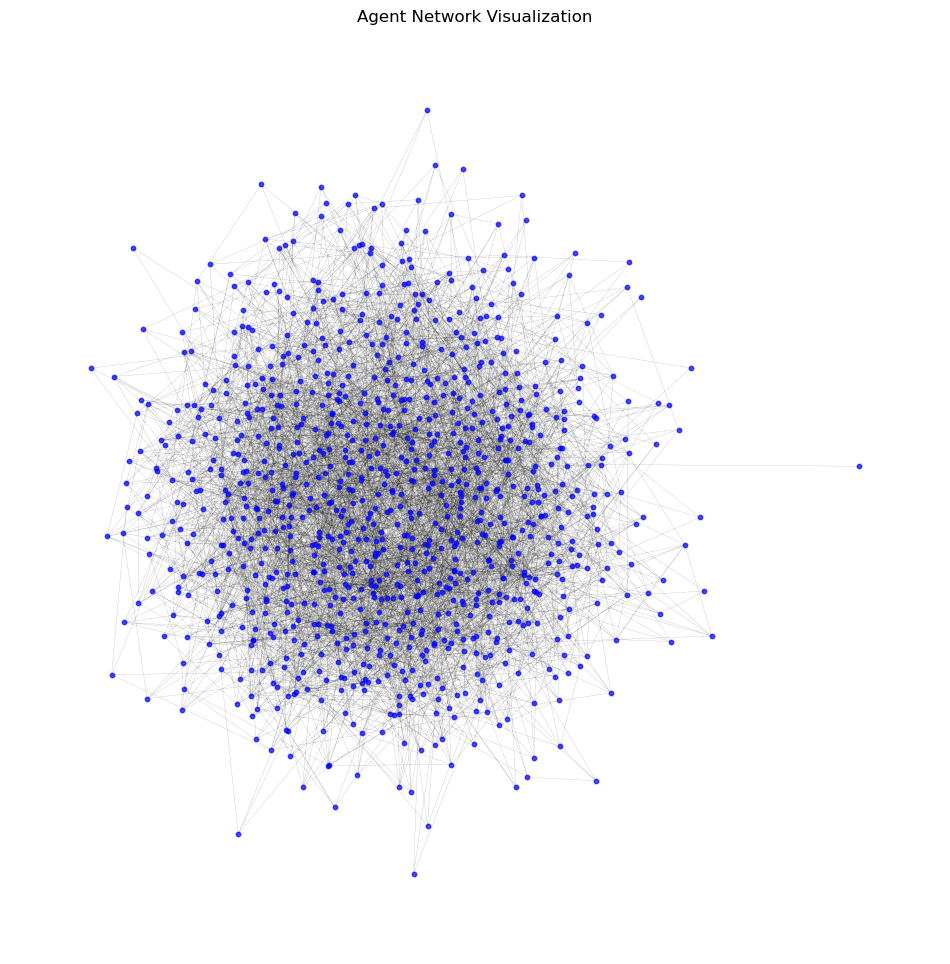

In [40]:



import networkx as nx

# Create a network using NetworkX
G = nx.Graph()

# Add nodes for each agent
for agent in agents:
    G.add_node(agent.agent_id)

# Add edges between agents based on shared homes or workplaces (Strong Ties)
home_groups = {}  # To track which agents are in the same home
workplace_groups = {}  # To track which agents are in the same workplace

for agent in agents:
    # Add agents to home groups
    home_id = agent.home
    if home_id not in home_groups:
        home_groups[home_id] = []
    home_groups[home_id].append(agent.agent_id)
    
    # Add agents to workplace groups
    workplace_id = agent.destination
    if agent.destination_type == "Workplace":
        if workplace_id not in workplace_groups:
            workplace_groups[workplace_id] = []
        workplace_groups[workplace_id].append(agent.agent_id)

# Create strong ties (home connections)
for home_id, members in home_groups.items():
    if len(members) > 1:  # Only create edges if there's more than one person in the home
        for i in range(len(members)):
            for j in range(i + 1, len(members)):
                G.add_edge(members[i], members[j])

# Create strong ties (workplace connections)
for workplace_id, members in workplace_groups.items():
    if len(members) > 1:  # Only create edges if there's more than one person in the workplace
        for i in range(len(members)):
            for j in range(i + 1, len(members)):
                G.add_edge(members[i], members[j])

# Add random connections between agents to create weak ties (Random Friends)
num_agents = len(agents)
random_friend_connections = 3000  # Arbitrary number of random connections to add

for _ in range(random_friend_connections):
    agent1 = random.randint(0, num_agents - 1)
    agent2 = random.randint(0, num_agents - 1)
    if agent1 != agent2 and not G.has_edge(agent1, agent2):
        G.add_edge(agent1, agent2)

# Check the number of nodes and edges in the network
print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")


import matplotlib.pyplot as plt
import random

# Set seed for reproducibility
random.seed(42)

# Create a layout for the nodes (using spring layout for more visually appealing placement)
layout = nx.spring_layout(G, seed=42)

# Draw the nodes
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, layout, node_size=10, node_color='blue', alpha=0.7)

# Draw the edges
nx.draw_networkx_edges(G, layout, alpha=0.3, width=0.2)

# Hide axis
plt.axis('off')

# Show plot
plt.title("Agent Network Visualization")
plt.show()